In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


(-0.5, 255.5, 255.5, -0.5)

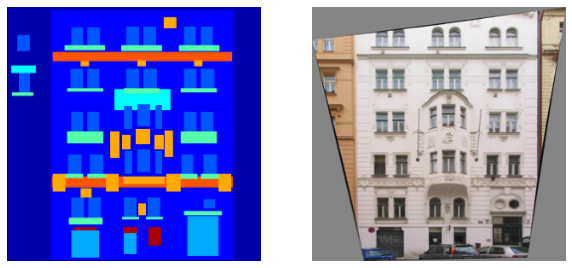

In [25]:
from os import listdir
from os.path import join
import random
import matplotlib.pyplot as plt

import os
import time
from PIL import Image
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.transforms.functional import to_pil_image

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


class FacadeDataset(Dataset):
    def __init__(self, path2img, direction='b2a', transform=False):
        super().__init__()
        self.direction = direction
        self.path2a = join(path2img, 'a')
        self.path2b = join(path2img, 'b')
        self.img_filenames = [x for x in listdir(self.path2a)]
        self.transform = transform

    def __getitem__(self, index):
        a = Image.open(join(self.path2a, self.img_filenames[index])).convert('RGB')
        b = Image.open(join(self.path2b, self.img_filenames[index])).convert('RGB')
        
        if self.transform:
            a = self.transform(a)
            b = self.transform(b)

        if self.direction == 'b2a':
            return b,a
        else:
            return a,b

    def __len__(self):
        return len(self.img_filenames)

transform = transforms.Compose([
                    transforms.ToTensor(),
                    transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5]),
                    transforms.Resize((256,256))
])

path2img = '/content/drive/MyDrive/data1/train'
train_ds = FacadeDataset(path2img, transform=transform)

a,b = train_ds[0]
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(to_pil_image(0.5*a+0.5))
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(to_pil_image(0.5*b+0.5))
plt.axis('off')

In [26]:
train_dl = DataLoader(train_ds, batch_size=32, shuffle=True)

In [27]:
# UNet
class UNetDown(nn.Module):
    def __init__(self, in_channels, out_channels, normalize=True, dropout=0.0):
        super().__init__()

        layers = [nn.Conv2d(in_channels, out_channels, 4, stride=2, padding=1, bias=False)]

        if normalize:
            layers.append(nn.InstanceNorm2d(out_channels)),

        layers.append(nn.LeakyReLU(0.2))

        if dropout:
            layers.append(nn.Dropout(dropout))

        self.down = nn.Sequential(*layers)

    def forward(self, x):
        x = self.down(x)
        return x

# check
x = torch.randn(16, 3, 256,256, device=device)
model = UNetDown(3,64).to(device)
down_out = model(x)
print(down_out.shape)

torch.Size([16, 64, 128, 128])


In [28]:
class UNetUp(nn.Module):
    def __init__(self, in_channels, out_channels, dropout=0.0):
        super().__init__()

        layers = [
            nn.ConvTranspose2d(in_channels, out_channels,4,2,1,bias=False),
            nn.InstanceNorm2d(out_channels),
            nn.LeakyReLU()
        ]

        if dropout:
            layers.append(nn.Dropout(dropout))

        self.up = nn.Sequential(*layers)

    def forward(self,x,skip):
        x = self.up(x)
        x = torch.cat((x,skip),1)
        return x

# check
x = torch.randn(16, 128, 64, 64, device=device)
model = UNetUp(128,64).to(device)
out = model(x,down_out)
print(out.shape)

torch.Size([16, 128, 128, 128])


In [29]:
# generator: 가짜 이미지를 생성합니다.
class GeneratorUNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=3):
        super().__init__()

        self.down1 = UNetDown(in_channels, 64, normalize=False)
        self.down2 = UNetDown(64,128)                 
        self.down3 = UNetDown(128,256)               
        self.down4 = UNetDown(256,512,dropout=0.5) 
        self.down5 = UNetDown(512,512,dropout=0.5)      
        self.down6 = UNetDown(512,512,dropout=0.5)             
        self.down7 = UNetDown(512,512,dropout=0.5)              
        self.down8 = UNetDown(512,512,normalize=False,dropout=0.5)

        self.up1 = UNetUp(512,512,dropout=0.5)
        self.up2 = UNetUp(1024,512,dropout=0.5)
        self.up3 = UNetUp(1024,512,dropout=0.5)
        self.up4 = UNetUp(1024,512,dropout=0.5)
        self.up5 = UNetUp(1024,256)
        self.up6 = UNetUp(512,128)
        self.up7 = UNetUp(256,64)
        self.up8 = nn.Sequential(
            nn.ConvTranspose2d(128,3,4,stride=2,padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        d1 = self.down1(x)
        d2 = self.down2(d1)
        d3 = self.down3(d2)
        d4 = self.down4(d3)
        d5 = self.down5(d4)
        d6 = self.down6(d5)
        d7 = self.down7(d6)
        d8 = self.down8(d7)

        u1 = self.up1(d8,d7)
        u2 = self.up2(u1,d6)
        u3 = self.up3(u2,d5)
        u4 = self.up4(u3,d4)
        u5 = self.up5(u4,d3)
        u6 = self.up6(u5,d2)
        u7 = self.up7(u6,d1)
        u8 = self.up8(u7)

        return u8

# check
x = torch.randn(16,3,256,256,device=device)
model = GeneratorUNet().to(device)
out = model(x)
print(out.shape)

torch.Size([16, 3, 256, 256])


In [30]:
class Dis_block(nn.Module):
    def __init__(self, in_channels, out_channels, normalize=True):
        super().__init__()

        layers = [nn.Conv2d(in_channels, out_channels, 3, stride=2, padding=1)]
        if normalize:
            layers.append(nn.InstanceNorm2d(out_channels))
        layers.append(nn.LeakyReLU(0.2))
    
        self.block = nn.Sequential(*layers)

    def forward(self, x):
        x = self.block(x)
        return x

# check
x = torch.randn(16,64,128,128,device=device)
model = Dis_block(64,128).to(device)
out = model(x)
print(out.shape)

torch.Size([16, 128, 64, 64])


In [31]:
# Discriminator은 patch gan을 사용합니다.
# Patch Gan: 이미지를 16x16의 패치로 분할하여 각 패치가 진짜인지 가짜인지 식별합니다.
# high-frequency에서 정확도가 향상됩니다.

class Discriminator(nn.Module):
    def __init__(self, in_channels=3):
        super().__init__()

        self.stage_1 = Dis_block(in_channels*2,64,normalize=False)
        self.stage_2 = Dis_block(64,128)
        self.stage_3 = Dis_block(128,256)
        self.stage_4 = Dis_block(256,512)

        self.patch = nn.Conv2d(512,1,3,padding=1) # 16x16 패치 생성

    def forward(self,a,b):
        x = torch.cat((a,b),1)
        x = self.stage_1(x)
        x = self.stage_2(x)
        x = self.stage_3(x)
        x = self.stage_4(x)
        x = self.patch(x)
        x = torch.sigmoid(x)
        return x
# check
x = torch.randn(16,3,256,256,device=device)
model = Discriminator().to(device)
out = model(x,x)
print(out.shape)

torch.Size([16, 1, 16, 16])


In [32]:
model_gen = GeneratorUNet().to(device)
model_dis = Discriminator().to(device)

In [33]:
# 가중치 초기화
def initialize_weights(model):
    class_name = model.__class__.__name__
    if class_name.find('Conv') != -1:
        nn.init.normal_(model.weight.data, 0.0, 0.02)


# 가중치 초기화 적용
model_gen.apply(initialize_weights);
model_dis.apply(initialize_weights);

In [34]:
# 손실함수
loss_func_gan = nn.BCELoss()
loss_func_pix = nn.L1Loss()

# loss_func_pix 가중치
lambda_pixel = 100

# patch 수
patch = (1,256//2**4,256//2**4)

# 최적화 파라미터
from torch import optim
lr = 2e-4
beta1 = 0.5
beta2 = 0.999

opt_dis = optim.Adam(model_dis.parameters(),lr=lr,betas=(beta1,beta2))
opt_gen = optim.Adam(model_gen.parameters(),lr=lr,betas=(beta1,beta2))

In [35]:
# 학습
model_gen.train()
model_dis.train()

batch_count = 0
num_epochs = 10 #수정
start_time = time.time()

loss_hist = {'gen':[],
             'dis':[]}

for epoch in range(num_epochs):
    for a, b in train_dl:
        ba_si = a.size(0)

        # real image
        real_a = a.to(device)
        real_b = b.to(device)

        # patch label
        real_label = torch.ones(ba_si, *patch, requires_grad=False).to(device)
        fake_label = torch.zeros(ba_si, *patch, requires_grad=False).to(device)

        # generator
        model_gen.zero_grad()

        fake_b = model_gen(real_a) # 가짜 이미지 생성
        out_dis = model_dis(fake_b, real_b) # 가짜 이미지 식별

        gen_loss = loss_func_gan(out_dis, real_label)
        pixel_loss = loss_func_pix(fake_b, real_b)

        g_loss = gen_loss + lambda_pixel * pixel_loss
        g_loss.backward()
        opt_gen.step()

        # discriminator
        model_dis.zero_grad()

        out_dis = model_dis(real_b, real_a) # 진짜 이미지 식별
        real_loss = loss_func_gan(out_dis,real_label)
        
        out_dis = model_dis(fake_b.detach(), real_a) # 가짜 이미지 식별
        fake_loss = loss_func_gan(out_dis,fake_label)

        d_loss = (real_loss + fake_loss) / 2.
        d_loss.backward()
        opt_dis.step()

        loss_hist['gen'].append(g_loss.item())
        loss_hist['dis'].append(d_loss.item())

        batch_count += 1
        if batch_count % 100 == 0:
            print('Epoch: %.0f, G_Loss: %.6f, D_Loss: %.6f, time: %.2f min' %(epoch, g_loss.item(), d_loss.item(), (time.time()-start_time)/60))

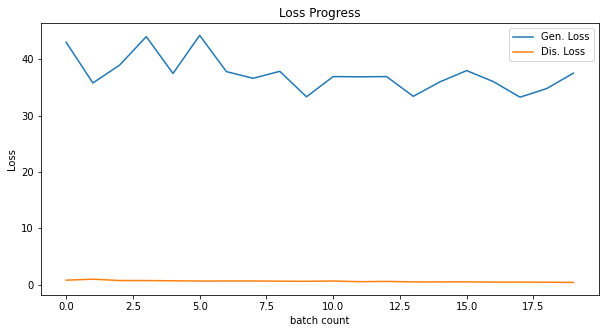

In [36]:
# loss history
plt.figure(figsize=(10,5))
plt.title('Loss Progress')
plt.plot(loss_hist['gen'], label='Gen. Loss')
plt.plot(loss_hist['dis'], label='Dis. Loss')
plt.xlabel('batch count')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [37]:
# 가중치 저장
path2models = './models/'
os.makedirs(path2models, exist_ok=True)
path2weights_gen = os.path.join(path2models, 'weights_gen.pt')
path2weights_dis = os.path.join(path2models, 'weights_dis.pt')

torch.save(model_gen.state_dict(), path2weights_gen)
torch.save(model_dis.state_dict(), path2weights_dis)

In [38]:
# 가중치 불러오기
weights = torch.load(path2weights_gen)
model_gen.load_state_dict(weights)

<All keys matched successfully>

In [39]:
# evaluation model
model_gen.eval()

# 가짜 이미지 생성
with torch.no_grad():
    for a,b in train_dl:
        fake_imgs = model_gen(a.to(device)).detach().cpu()
        real_imgs = b
        break

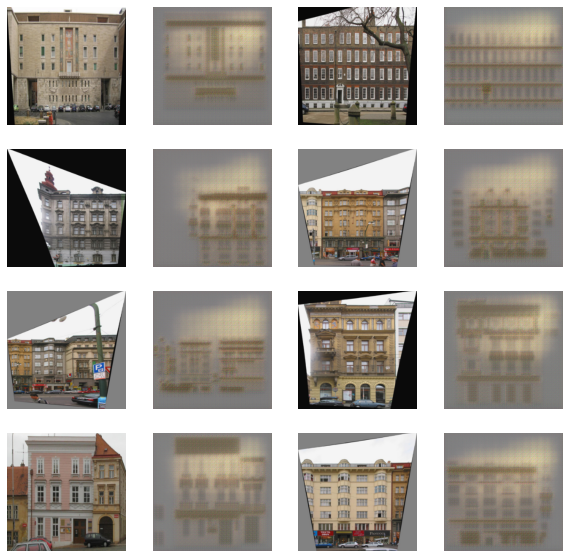

In [40]:
# 가짜 이미지 시각화
plt.figure(figsize=(10,10))

for ii in range(0,16,2):
    plt.subplot(4,4,ii+1)
    plt.imshow(to_pil_image(0.5*real_imgs[ii]+0.5))
    plt.axis('off')
    plt.subplot(4,4,ii+2)
    plt.imshow(to_pil_image(0.5*fake_imgs[ii]+0.5))
    plt.axis('off')